#   XGBoost模型调优

##  加载要用的库

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_decomposition,metrics

#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 12,4

###  载入数据

## 载入数据

上一个ipython notebook已经做了下面这些数据特征预处理
1. City因为类别太多丢掉
2. DOB生成Age字段，然后丢掉原字段
3. EMI_Loan_Submitted_Missing 为1(EMI_Loan_Submitted) 为0(EMI_Loan_Submitted缺省) EMI_Loan_Submitted丢掉
4. EmployerName丢掉
5. Existing_EMI对缺省值用均值填充
6. Interest_Rate_Missing同 EMI_Loan_Submitted
7. Lead_Creation_Date丢掉
8. Loan_Amount_Applied, Loan_Tenure_Applied 均值填充
9. Loan_Amount_Submitted_Missing 同 EMI_Loan_Submitted 
10. Loan_Tenure_Submitted_Missing 同 EMI_Loan_Submitted
11. LoggedIn, Salary_Account 丢掉
12. Processing_Fee_Missing 同 EMI_Loan_Submitted
13. Source - top 2 kept as is and all others combined into different category
14. Numerical变化 和 One-Hot编码

In [2]:
train = pd.read_csv("train_modified.csv")
test = pd.read_csv("test_modified.csv")
train.shape, test.shape

((87020, 51), (37717, 50))

In [3]:
target = "Disbursed"
IDcol = "ID"


In [ ]:
# train['Disbursed'].value_counts()

## 建模与交叉验证

写一个大的函数完成以下的功能
1. 数据建模
2. 求训练准确率
3. 求训练集AUC
4. 根据xgboost交叉验证更新n_estimators
5. 画出特征的重要度 

In [ ]:
def modelfit(alg, dtrain, dtest, predicts, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predicts].values,label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predicts].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_xgb_params()['n_estimators'], 
                          nfold=cv_folds,early_stopping_rounds=early_stopping_rounds
                         )
        alg.set_params(n_estimators = cvresult.shape[0])
        
        
    # 建立模型
    alg.fit(dtrain[predicts], dtrain["Disbursed"],eval_metric='auc')
    
    # 对训练集进行预测
    dtrain_predicitions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # 输出模型的一些结果
    print("\n 关于这个模型")
    print("准确率: %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predicitions))
    print("AUC 得分为(训练集是)：%f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    
    # print("******",alg.get_booster())
    # print("----",pd.Series(alg.get_booster().get_fscore()))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance score')
    

    

##  第一步- 对于高的学习率找到最合适的 estimators个数


 关于这个模型
准确率: 0.9854
AUC 得分为(训练集是)：0.829632


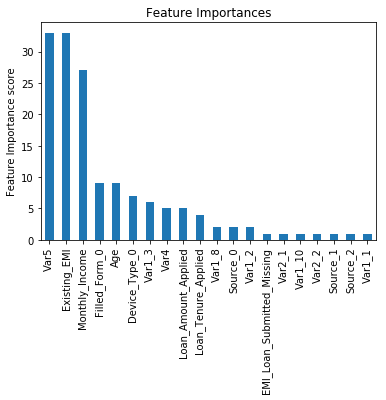

In [ ]:
predictors = [x  for x in train.columns if x  not in [target, IDcol]]
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=10,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27
                    )
modelfit(xgb1, train, test, predictors)

## 对subsample 和 max_features 用grid search查找最好的参数


In [ ]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_chil_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=140,
                                               max_depth=5, min_child_weight=1,
                                               gamma=0, subsample=0.8,colsample_bytree=0.8,
                                               objective='binary:logistic',nthread=4,
                                               scale_pos_weight1=1,seed=27),
                       param_grid=param_test1, scoring="roc_auc", n_jobs=4, iid=False, cv=5)
gsearch1.fit(train[predictors], train[target])

In [ ]:
gsearch1.grid